v.1 - 2021-07-14

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Calculations

In [2]:
# constants
ExcessMortalityApr20toApr21 = 43263
MortalityOfficialAprtoJul = 4800
PopulationMoscow = 12651000
FullyVaccinated = 1800000
SemiVaccinated  = 3200000-FullyVaccinated
VaccinatedGroups =   {'FullyVaccinated':FullyVaccinated,
                      'SemiVaccinated' :SemiVaccinated}

# HIGH and LOW refers to scenario type, not arithmetic value.
MortalityUndercountCoeff = {'low':1.5 , 'mean':1.75 , 'high':2 }
IFR                      = {'high':0.005 , 'mean':0.0066 , 'low':0.0084 } 

# asymptomatics share is 0.33- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7839426/
# so OR_Symptomatic for NonImmune should be 1-0.33=0.66
OR_Symptomatic = {'FullyVaccinated':{'high':0.33,'mean':0.2, 'low':0.12},
                  'SemiVaccinated' :{'high':0.7, 'mean':0.69,'low':0.64},
                  'Convalescent'   :{'high':0.2, 'mean':0.2, 'low':0.2},
                  'NonImmune'      :{'high':0.66, 'mean':0.66,'low':0.66}}

HospitalizationOfficialJuntoJul9 = 62127

OR_Hospitalization = {'FullyVaccinated':{'high':0.08, 'mean':0.06, 'low':0.04},
                      'SemiVaccinated' :{'high':0.29, 'mean':0.25, 'low':0.06},
                      'Convalescent'   :{'high':0.04, 'mean':0.04, 'low':0.04},} # MOCK VALUES ON CONVALESCENT!

# Functions

## Symptomatic Infections
def get_ExpectedSymptomaticNumber(N, Group, Scenario='mean'):
    EstimatedShareOfGroupInN =get_GroupNumber(Group, Scenario)/PopulationMoscow*N
    return EstimatedShareOfGroupInN*get_SymptomaticShareInGroup(Group, Scenario)

def get_SymptomaticShareInGroup(Group, Scenario='mean'):
    return get_SymptomaticInGroup(Group, Scenario)/get_GroupNumber(Group, Scenario)
    
def get_SymptomaticInGroup(Group, Scenario='mean'):
#     доля группы × шансы заболеть × число заболевших по смертям 45 дней
    SymptomaticInGroup = (get_GroupNumber(Group, Scenario)/PopulationMoscow)\
                        *OR_Symptomatic[Group][Scenario]\
                        *get_TrueInfectionsNumber45d(Scenario)
    return SymptomaticInGroup

## Hospitalizations
def get_ExpectedHospitalizedNumber(N, Group, Scenario='mean'):
    EstimatedShareOfGroupInN =get_GroupNumber(Group, Scenario)/PopulationMoscow*N
    return EstimatedShareOfGroupInN*get_HospitalizedShareInGroup(Group, Scenario)
    
def get_HospitalizedShareInGroup(Group, Scenario='mean'):
    return get_HospitalizedInGroup(Group, Scenario)/get_GroupNumber(Group, Scenario)
    
def get_HospitalizedInGroup(Group, Scenario='mean'):
#     доля группы × шансы заболеть × число официально госпитализированных
    HospitalizedInGroup = (get_GroupNumber(Group, Scenario)/PopulationMoscow)\
                        *OR_Hospitalization[Group][Scenario]\
                        *HospitalizationOfficialJuntoJul9
    return HospitalizedInGroup

## Other Functions
def get_TrueInfectionsNumber45d(Scenario):
    TrueRecentMortality = MortalityOfficialAprtoJul * MortalityUndercountCoeff[Scenario]
    TrueInfectionsNumber45d = TrueRecentMortality/IFR[Scenario]
    return TrueInfectionsNumber45d

def get_GroupNumber(Group, Scenario='mean'):
    if Group not in OR_Symptomatic.keys():
        raise 'Incorrect Group!'
    elif Group in VaccinatedGroups.keys():
        return VaccinatedGroups[Group]
    elif Group == 'Convalescent':
        return get_ConvalescentNumber(Scenario)
    elif Group == 'NonImmune':
        return PopulationMoscow-get_ConvalescentNumber(Scenario)-FullyVaccinated-SemiVaccinated
    
def get_ConvalescentNumber(Scenario):
    return (ExcessMortalityApr20toApr21\
                          +\
                          MortalityOfficialAprtoJul*MortalityUndercountCoeff[Scenario])\
                     /IFR[Scenario]

# DataFrames

In [3]:
# df_FullyVaccinated
N_min = 1
N_max = 1000
df_FullyVaccinated = pd.DataFrame(
            {'low':[get_ExpectedSymptomaticNumber(i, 'FullyVaccinated', 'low') for i in range(N_min,N_max)],
             'mean':[get_ExpectedSymptomaticNumber(i, 'FullyVaccinated', 'mean') for i in range(N_min,N_max)],
             'high':[get_ExpectedSymptomaticNumber(i, 'FullyVaccinated', 'high') for i in range(N_min,N_max)]
            },
            index=list(range(N_min,N_max))    
                                )
# df_SemiVaccinated
N_min = 1
N_max = 1000
df_SemiVaccinated = pd.DataFrame(
            {'low':[get_ExpectedSymptomaticNumber(i, 'SemiVaccinated', 'low') for i in range(N_min,N_max)],
             'mean':[get_ExpectedSymptomaticNumber(i, 'SemiVaccinated', 'mean') for i in range(N_min,N_max)],
             'high':[get_ExpectedSymptomaticNumber(i, 'SemiVaccinated', 'high') for i in range(N_min,N_max)]
            },
            index=list(range(N_min,N_max))    
                                )
# df_Convalescent
N_min = 1
N_max = 1000
df_Convalescent = pd.DataFrame(
            {'low':[get_ExpectedSymptomaticNumber(i, 'Convalescent', 'low') for i in range(N_min,N_max)],
             'mean':[get_ExpectedSymptomaticNumber(i, 'Convalescent', 'mean') for i in range(N_min,N_max)],
             'high':[get_ExpectedSymptomaticNumber(i, 'Convalescent', 'high') for i in range(N_min,N_max)]
            },
            index=list(range(N_min,N_max))    
                                )


# df_FullyVaccinated_Hospitalizied
N_min = 1
N_max = 1000
df_FullyVaccinated_Hospitalizied = pd.DataFrame(
            {'low': [get_ExpectedHospitalizedNumber(i, 'FullyVaccinated', 'low') for i in range(N_min,N_max)],
             'mean':[get_ExpectedHospitalizedNumber(i, 'FullyVaccinated', 'mean') for i in range(N_min,N_max)],
             'high':[get_ExpectedHospitalizedNumber(i, 'FullyVaccinated', 'high') for i in range(N_min,N_max)]
            },
            index=list(range(N_min,N_max))    
                                )

# df_SemiVaccinated_Hospitalizied
N_min = 1
N_max = 1000
df_SemiVaccinated_Hospitalizied = pd.DataFrame(
            {'low':[get_ExpectedHospitalizedNumber(i, 'SemiVaccinated', 'low') for i in range(N_min,N_max)],
             'mean':[get_ExpectedHospitalizedNumber(i, 'SemiVaccinated', 'mean') for i in range(N_min,N_max)],
             'high':[get_ExpectedHospitalizedNumber(i, 'SemiVaccinated', 'high') for i in range(N_min,N_max)]
            },
            index=list(range(N_min,N_max))    
                                )
# df_Convalescent_Hospitalized
N_min = 1
N_max = 1000
df_Convalescent_Hospitalized = pd.DataFrame(
            {'low':[get_ExpectedHospitalizedNumber(i, 'Convalescent', 'low') for i in range(N_min,N_max)],
             'mean':[get_ExpectedHospitalizedNumber(i, 'Convalescent', 'mean') for i in range(N_min,N_max)],
             'high':[get_ExpectedHospitalizedNumber(i, 'Convalescent', 'high') for i in range(N_min,N_max)]
            },
            index=list(range(N_min,N_max))    
                                )


# Figs

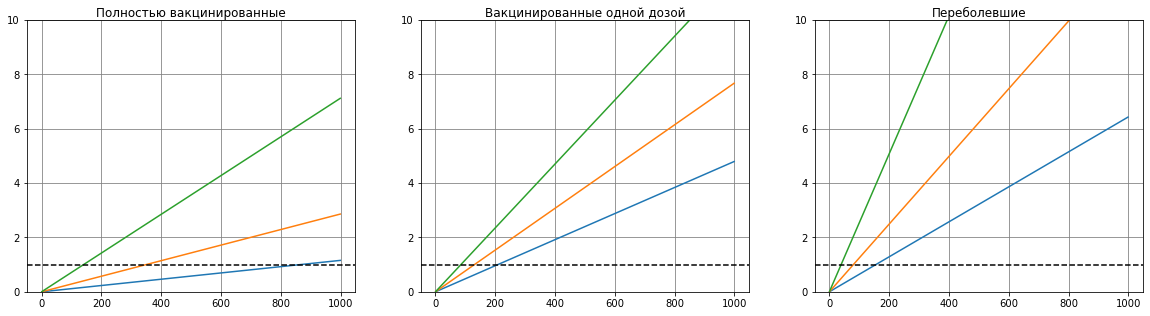

In [4]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
# ax.set_xscale('log')
axs[0].set_ylim(0,10)
# ax.set_facecolor('black')
axs[0].grid(color='gray')

# plt.plot(df_FullyVaccinated)
#          , c='white', marker= 'o', alpha=1, linestyle='None')
axs[0].plot(df_FullyVaccinated)

# ==

# ax.set_xscale('log')
axs[1].set_ylim(0,10)
# ax.set_facecolor('black')
axs[1].grid(color='gray')

# plt.plot(df_FullyVaccinated)
#          , c='white', marker= 'o', alpha=1, linestyle='None')
axs[1].plot(df_SemiVaccinated)

# ==


# ax.set_xscale('log')
axs[2].set_ylim(0,10)
# ax.set_facecolor('black')
axs[2].grid(color='gray')

# plt.plot(df_FullyVaccinated)
#          , c='white', marker= 'o', alpha=1, linestyle='None')
axs[2].plot(df_Convalescent)

# ==


axs[0].axhline(y=1, color='black', linestyle='--')
axs[0].set_title('Полностью вакцинированные', c='black', pad=-20)

axs[1].axhline(y=1, color='black', linestyle='--')
axs[1].set_title('Вакцинированные одной дозой', c='black', pad=-20)

axs[2].axhline(y=1, color='black', linestyle='--')
axs[2].set_title('Переболевшие', c='black', pad=-20)

plt.savefig('pic_1_All_Symptomatic.svg')


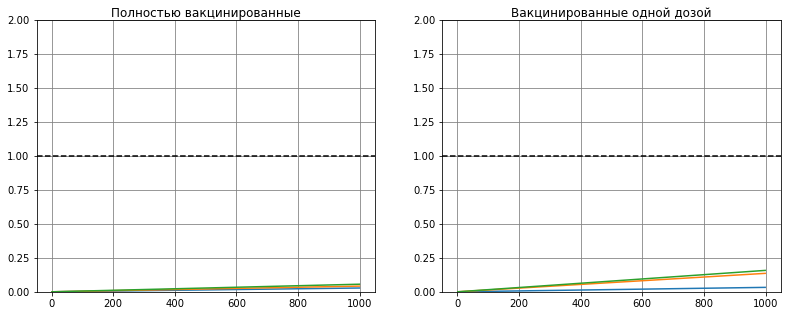

In [5]:
fig, axs = plt.subplots(1,2, figsize=(2/3*20,5))
# ax.set_xscale('log')
axs[0].set_ylim(0,2)
# ax.set_facecolor('black')
axs[0].grid(color='gray')

# plt.plot(df_FullyVaccinated_Hospitalized)
#          , c='white', marker= 'o', alpha=1, linestyle='None')
axs[0].plot(df_FullyVaccinated_Hospitalizied)

# ==

# ax.set_xscale('log')
axs[1].set_ylim(0,2)
# ax.set_facecolor('black')
axs[1].grid(color='gray')

# plt.plot(df_FullyVaccinated_Hospitalized)
#          , c='white', marker= 'o', alpha=1, linestyle='None')
axs[1].plot(df_SemiVaccinated_Hospitalizied)

# ==


# # ax.set_xscale('log')
# axs[2].set_ylim(0,2)
# # ax.set_facecolor('black')
# axs[2].grid(color='gray')

# # plt.plot(df_FullyVaccinated_Hospitalized)
# #          , c='white', marker= 'o', alpha=1, linestyle='None')
# axs[2].plot(df_Convalescent_Hospitalized)

# ==


axs[0].axhline(y=1, color='black', linestyle='--')
axs[0].set_title('Полностью вакцинированные', c='black', pad=-20)

axs[1].axhline(y=1, color='black', linestyle='--')
axs[1].set_title('Вакцинированные одной дозой', c='black', pad=-20)

# axs[2].axhline(y=1, color='black', linestyle='--')
# axs[2].set_title('Переболевшие', c='black', pad=-20)

plt.savefig('pic_1_All_Hospitalized.svg')
